# DTW alignment on the basis of energy

(suggested by results from MFCC tests in vowel-discri git).

In [1]:
%matplotlib inline

# generic imports
import numpy as np
import os.path as path

# for feature extraction/storage
import soundfile
import librosa
import h5features
import reps
import dtw
import cosine
import scipy.spatial.distance as dis

# results analysis / plots
from scone_phobia import apply_analysis
from scone_phobia.analyses.avg_error import avg_error
import scone_phobia.metadata.add_metadata as add_metadata
import matplotlib.pyplot as plt
import seaborn as sns

/Users/admin/anaconda/lib/python3.5/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
def read_wav(wavefile, onset=None, offset=None):
    data, fs = soundfile.read(wavefile)
    assert fs==16000
    if onset is None:
        onset = 0
    if offset is None:
        offset = len(data)/float(fs)
    times = 1/(2*float(fs)) + np.arange(len(data))/float(fs)
    data = data[(times>=onset) & (times<=offset)]
    return data, fs


def extract_mfcc(wav_folder, segments_file, out_file, **kwargs):
    segments = {}
    with open(segments_file, 'r') as fh:
        for line in fh:
            seg, wav, onset, offset = line.strip().split()
            onset, offset = float(onset), float(offset)
            segments[seg] = wav, onset, offset
    utts, feats, times = [], [], []
    for i, seg in enumerate(segments):
        if i % 100 == 0:
            print("Done {} / {}".format(i, len(segments)))
        wav, onset, offset = segments[seg]
        wavefile = path.join(wav_folder, wav)
        data, fs = read_wav(wavefile, onset=onset, offset=offset)
        assert fs == 16000
        coefs = reps.mfcc(data, **kwargs)
        feats.append(coefs.T)
        utts.append(seg)
        times.append(0.0125 + np.arange(coefs.shape[1])*0.01)
    data = h5features.Data(utts, times, feats, check=True)
    with h5features.Writer(out_file) as fh:
        fh.write(data, '/features')

## Qualitative tests

### Input features

In [3]:
data, fs = librosa.load('../test/bras.wav', sr=16000)

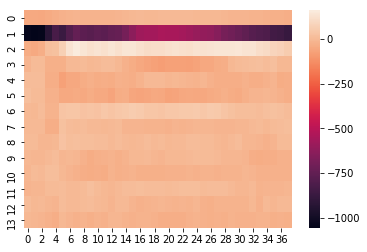

In [4]:
coefs = reps.mfcc(data, zeroth_coef='concatenate logE')
sns.heatmap(coefs[:, :])

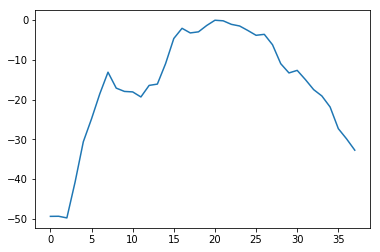

In [5]:
sns.lineplot(data=coefs[0,:])  # log-energy

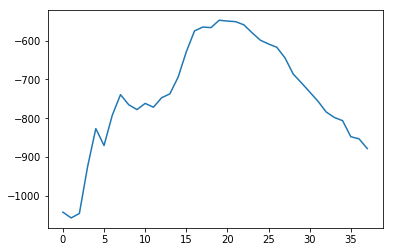

In [6]:
sns.lineplot(data=coefs[1,:])  # mfcc 0

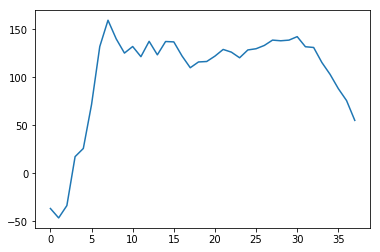

In [7]:
sns.lineplot(data=coefs[2,:])  # mfcc 1

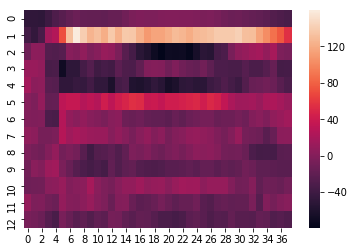

In [8]:
coefs = reps.mfcc(data, zeroth_coef='replace 0 with logE')
sns.heatmap(coefs[:, :])

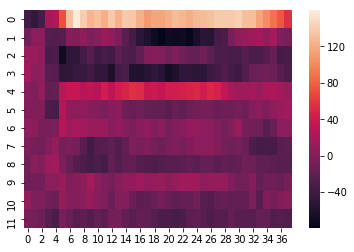

In [9]:
coefs = reps.mfcc(data, zeroth_coef='remove 0')
sns.heatmap(coefs[:, :])

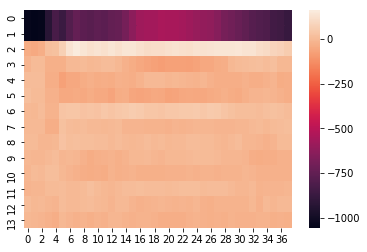

In [10]:
coefs = reps.mfcc(data, zeroth_coef='duplicate 0')
sns.heatmap(coefs[:, :])

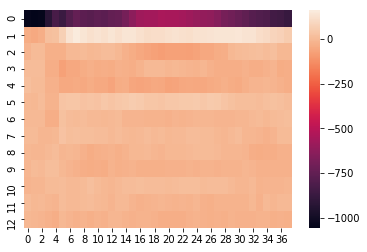

In [11]:
coefs = reps.mfcc(data)
sns.heatmap(coefs[:, :])

#### Dissimilarity functions

In [3]:
# Get some interesting waveforms to align from WSJ:
data1, fs = librosa.load('../test/amendment_WSJ_1.wav', sr=16000)
data2, fs = librosa.load('../test/amendment_WSJ_2.wav', sr=16000)
coefs1 = reps.mfcc(data1)
coefs2 = reps.mfcc(data2)

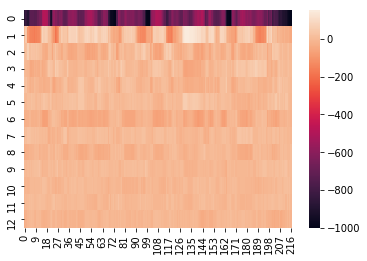

In [4]:
sns.heatmap(coefs1[:, :])

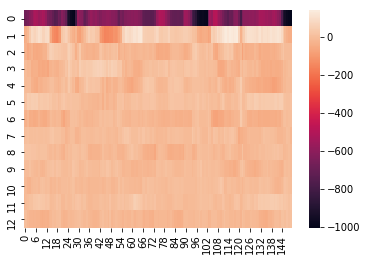

In [5]:
sns.heatmap(coefs2[:, :])

In [18]:
def alignment_then_diss(x1, x2, y1, y2, metric1, metric2, normalized=True):
    """
    Align x1, y1 with DTW based on metric1 and get distance
    using metric2 on x2, y2 along alignment path.
    
        - metric1: returns matrix of distances for all pairs of x1, y1 frames
        - metric2: returns vector of distances for matched pairs of same length
           arrays obtained by aligning x2 and y2
    """
    _, path = dtw.dtw(x1, y1, metric1, return_path=True)
    x = x2[path[:, 0], :]
    y = y2[path[:, 1], :]
    d = metric2(x, y)
    if normalized:
        return np.mean(d)
    else:
        return np.sum(d)
    

def dtw_on_logE(x, y, normalized, cosine_type='angular'):
    """
    x: [n_x, d] array
    y: [n_y, d] array

    This assumes the signal log-energy can be found on the first feature coordinate.
    """
    metric1 = lambda x, y: dis.cdist(x, y, 'euclidean')  # cosine on 1D data does not make sense
    if cosine_type == 'angular':
        metric2 = cosine.matched_angular
    elif cosine_type == 'cosine':
        metric2 = cosine.matched_cosine
    else:
        raise ValueError('Unsupported cosine_type value: {}'.format(cosine_type))
    return alignment_then_diss(x[:, :1], x[:, 1:], y[:, :1], y[:, 1:],
                               metric1, metric2, normalized=normalized)

In [31]:
dtw_on_logE(coefs1[:,:60].T, coefs2[:,:50].T, normalized=True)

0.7655330269508713

In [32]:
dtw_on_logE(coefs1[:,-60:].T, coefs2[:,-50:].T, normalized=True)

0.9268190502775876

## Test ABX discriminability on WSJ corpus

This requires some of the material from the "Early phonetic learning without phonetic categories" paper.


### First extract features of interest and store them in h5features format to allow testing ABX phone discriminability.

In [14]:
"""
Conditions

1-2. Basic MFCC with DTW-cosine vs angular
3-4. Basic MFCC with zeroth-order coefficient replaced by log-E with DTW-cosine vs angular
5-6. Basic MFCC without zeroth-order coefficient with DTW-cosine vs angular
7-8. log-E alignments, followed by cosine on aligned MFCC with or without 0-th coef
9-10. 0-th MFCC alignments, followed by cosine on aligned MFCC with or without 0-th coef

Also try HTK vs Slaney style MFCC? And liftering?
"""

root = '/Users/admin/Documents/PhD/Data/GPJ_match_WSJ_test/'
wav = root + 'wavs/'
seg = root + 'segments.txt'
out = root + 'logE_tests/mfcc_{}.features'
extract_mfcc(wav, seg, out.format('basic'), zeroth_coef=None)
print('1')
extract_mfcc(wav, seg, out.format('0=logE'), zeroth_coef='replace 0 with logE')
print('2')
extract_mfcc(wav, seg, out.format('no-0'), zeroth_coef='remove 0')
print('3')
extract_mfcc(wav, seg, out.format('0+logE'), zeroth_coef='concatenate logE')
print('4')
extract_mfcc(wav, seg, out.format('0+0'), zeroth_coef='duplicate 0')
print('5')

Done 0 / 4871
Done 100 / 4871
Done 200 / 4871
Done 300 / 4871
Done 400 / 4871
Done 500 / 4871
Done 600 / 4871
Done 700 / 4871
Done 800 / 4871
Done 900 / 4871
Done 1000 / 4871
Done 1100 / 4871
Done 1200 / 4871
Done 1300 / 4871
Done 1400 / 4871
Done 1500 / 4871
Done 1600 / 4871
Done 1700 / 4871
Done 1800 / 4871
Done 1900 / 4871
Done 2000 / 4871
Done 2100 / 4871
Done 2200 / 4871
Done 2300 / 4871
Done 2400 / 4871
Done 2500 / 4871
Done 2600 / 4871
Done 2700 / 4871
Done 2800 / 4871
Done 2900 / 4871
Done 3000 / 4871
Done 3100 / 4871
Done 3200 / 4871
Done 3300 / 4871
Done 3400 / 4871
Done 3500 / 4871
Done 3600 / 4871
Done 3700 / 4871
Done 3800 / 4871
Done 3900 / 4871
Done 4000 / 4871
Done 4100 / 4871
Done 4200 / 4871
Done 4300 / 4871
Done 4400 / 4871
Done 4500 / 4871
Done 4600 / 4871
Done 4700 / 4871
Done 4800 / 4871
1
Done 0 / 4871
Done 100 / 4871
Done 200 / 4871
Done 300 / 4871
Done 400 / 4871
Done 500 / 4871
Done 600 / 4871
Done 700 / 4871
Done 800 / 4871
Done 900 / 4871
Done 1000 / 4871
Do

## 2. Run WSJ discrimination on features (done on a remote cluster)

## 3. Plot results

In [ ]:
# Loading (or computing if it's the first time) avg_error analysis results with full resamples

mp_folder = '/Users/admin/Documents/PhD/Data/vowel_discri/mp_scores'

analysis = avg_error
df_avg = apply_analysis(analysis, mp_folder,
                        add_metadata=add_metadata.language_register,
                        resampling=False)

In [ ]:
sns.catplot(data=df_avg, kind='bar', y='error', hue='model type', x='contrast type')

Conclusion: for within-speaker phone discrimination:
    - cepstral mean normalization does not have much effect overall (tends to make consonant a bit harder to discriminate and vowel a bit easier) -> do not do it
    - log-energy: big effect unscaled zeroth-order MFCC appears best????
        - Does this have to do with DTW aligning signal based on energy profile due to scale unbalance???
            -> how come there is this unbalance in the first place, isn't this supposed to be a PCA?
                -> maybe log-energy synchronization (DTW or otherwise) + cosine distance on aligned signals without the energy would work very well? (or more generally on signal deconvoluted from pitch+prosody contours)
   
    - Short-term: take normalized DTW with basic MFCC (no log energy or removing of first coefficient) and no cepstral mean normalization. 